# Creating the Dataset

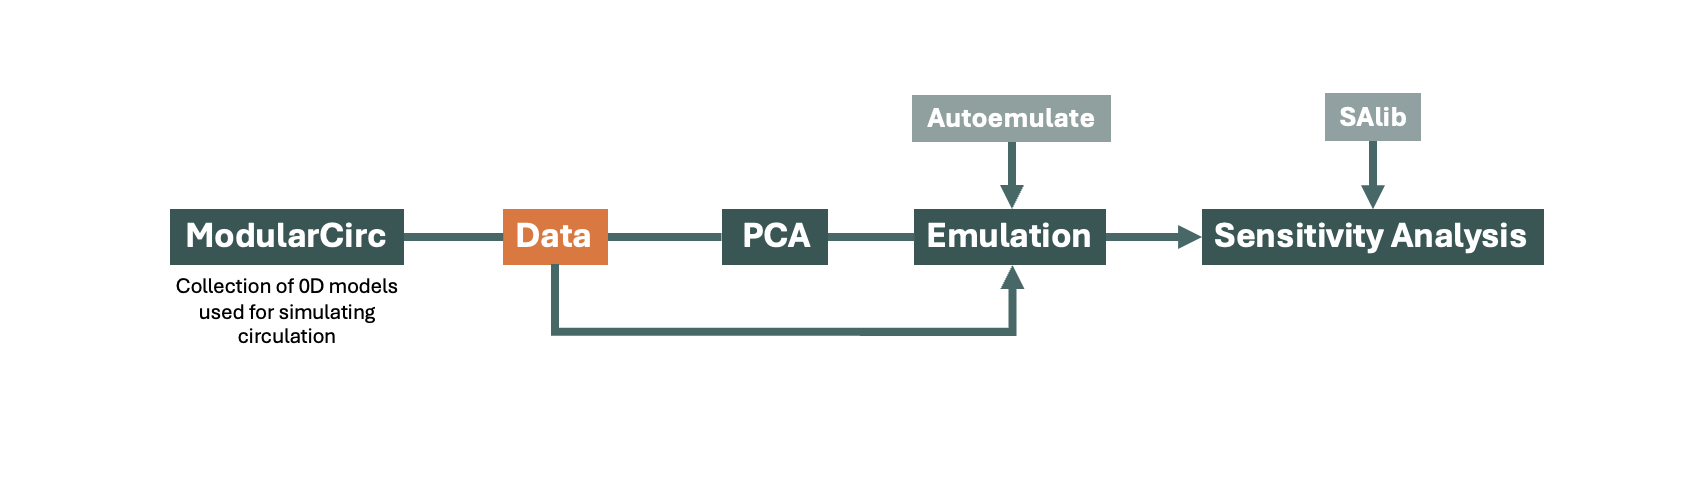

## Creating Parameter CSV file

### First step of creating the Dataset

This first step focuses on defining ranges parameters of different elements of the cardiac circulation (some ranged and some constant) – based on preset parameters from literature, and then randomising values for these parameters using [Latin hypercube](https://en.wikipedia.org/wiki/Latin_hypercube_sampling) (a statistical method for generating a near-random sample of parameter values).

In this case this tutorial focuses on the systemic circulation (as pictured below), ignoring the pulmonary circulation in order to simplify the simulation. However the logic used to complete this sensitivity analysis is applicable for pulmonary circulation also.

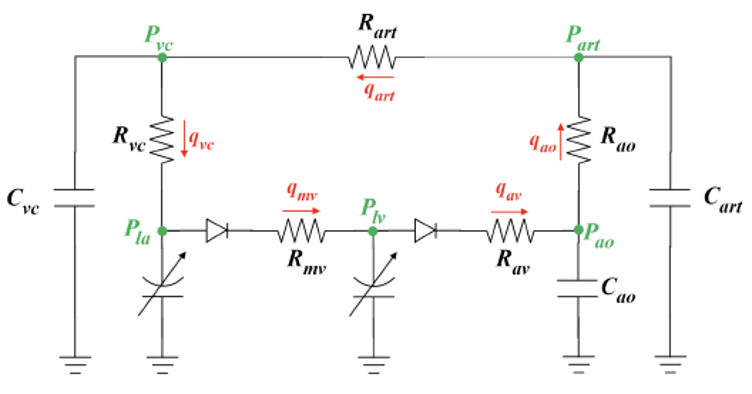

17 total paramters are extracted from this 0D model of the systemic circulation:
* Aortic Resistance = `ao.r`

* Aortic Capacitance = `ao.c`

* Arterial Resistance = `art.r`

* Arterial Capacitance = `art.c`

* Venous Resistance = `ven.r`

* Venous Capacitance = `ven.c`

* Aortic Valve Resistance = `av.r`

* Mitral Valve Resistance = `mv.r`

* Left Atrium Passive Stiffness Scaling = `la.E_pas`

* Left Atrium Active Stiffness Scaling = `la.E_act`

* Left Atrium Reference Volume = `la.v_ref`

* Left Atrium Active Stiffness Exponential = `la.k_pas`

* Left Ventricle Passive Stiffness Scaling = `lv.E_pas`

* Left Ventricle Active Stiffness Scaling = `la.E_pas`

* Left Ventricle Reference Volume = `lv.v_ref`

* Left Ventricle Passive Stiffness Exponential = `lv.k_pas`

* Heart Rate = `T`

The goal of this sensitivity analysis is to reduce this set of parameters to the ones that have most effect on arterial pressure and cardiac output. As a subset of parameters can be better optimised to fit to patient data.


### Instructions

Start by importing the necessary modules:
* Imported `LatinHypercube` from autoemulate module, experimental_design submodule.

* Imported `NaghaviModelParameters` from ModularCirc Models submodule.


In [4]:
%load_ext autoreload 
%autoreload 2

import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import os
import json
from autoemulate.experimental_design import LatinHypercube
from ModularCirc.Models.NaghaviModel import NaghaviModelParameters

import circ_utils
## Importing a .py file with functions needed to call the script to produce the output data

!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/lbokeria/projects/health_gc/cvd_net_project/ModularCirc/Tutorials/Tutorial_01


Define the folder path - adapt as necessary to your machine:

In [5]:
main_path = os.getcwd()

The first step towards creating the dataset is to import the dictonary that gives numerical values to parameters (listed above) for different structures in the heart, based on the Naghavi parameter values, with a range to allow for variablilty. Some values are constants and do not have  a range.

Use the function (defined in circ_utils) to condense the parameters into their respective groups (ranged or single) using the dictionary that we imported. 

In [6]:
with open('parameters.json', 'r') as file:
    dict_parameters = json.load(file)

circ_utils.condense_dict_parameters(dict_parameters)

Choose the number of parameter sets you would like to create, and randomise values for each parameter set - and make the results into a dataframe. These parameter sets will individually be used within 0D model simulations from ModularCirc.

In [7]:
N_samples = 2000
lhd = LatinHypercube(circ_utils.dict_parameters_condensed_range.values())
sample_array = lhd.sample(N_samples)
sample_df    = pd.DataFrame(sample_array, columns=circ_utils.dict_parameters_condensed_range.keys())
sample_df.index.name = 'Index'
sample_df.head()

,ao.r,ao.c,art.r,art.c,ven.r,ven.c,av.r,mv.r,la.E_pas,la.E_act,la.v_ref,la.k_pas,lv.E_pas,lv.E_act,lv.v_ref,lv.k_pas,T
Index,,,,,,,,,,,,,,,,,
0,251.531079,0.379459,759.345033,1.944001,6.948071,199.865868,4.503117,3.215838,0.468417,0.515297,8.063361,0.074185,1.434086,1.839927,10.370088,0.038444,803.909412
1,225.406510,0.270380,1496.956244,2.733919,9.041745,103.608452,3.457793,2.664551,0.405191,0.226537,14.707637,0.025079,1.381027,2.542220,11.488262,0.020579,870.620261
2,304.416578,0.244161,883.334621,3.669490,6.673086,132.444588,4.950421,4.736512,0.582314,0.327034,9.404336,0.060626,0.627475,3.688567,10.291633,0.020120,1062.484756
3,248.335686,0.204490,1088.792035,2.094966,5.422298,163.468099,8.199492,3.786400,0.518886,0.560059,6.224672,0.041572,1.301676,3.153664,5.496512,0.029945,985.028534
4,254.668221,0.364915,1285.551049,4.196007,7.052631,86.525077,6.873886,4.970855,0.356248,0.621640,6.945670,0.028086,0.551181,3.625220,6.796550,0.033582,1142.688235


Add the previously separated constants back into the new dataframe.

In [8]:
for key, val in circ_utils.dict_parameters_condensed_single.items():
    print(key, val)

    sample_df[key] = val
    
    sample_df[key] = val
    
sample_df.head()

ao.l 0
ao.v_ref 100
ao.v 130
art.l 0
art.v_ref 900
art.v 1092
ven.l 0.0
ven.v_ref 2800
ven.v 3780
la.v 93
la.delay 150
la.t_tr 225
la.tau 25
la.t_max 150
lv.delay 0
lv.t_tr 420
lv.tau 25
lv.t_max 280


,ao.r,ao.c,art.r,art.c,ven.r,ven.c,av.r,mv.r,la.E_pas,la.E_act,...,ven.v,la.v,la.delay,la.t_tr,la.tau,la.t_max,lv.delay,lv.t_tr,lv.tau,lv.t_max
Index,,,,,,,,,,,,,,,,,,,,,
0,251.531079,0.379459,759.345033,1.944001,6.948071,199.865868,4.503117,3.215838,0.468417,0.515297,...,3780,93,150,225,25,150,0,420,25,280
1,225.406510,0.270380,1496.956244,2.733919,9.041745,103.608452,3.457793,2.664551,0.405191,0.226537,...,3780,93,150,225,25,150,0,420,25,280
2,304.416578,0.244161,883.334621,3.669490,6.673086,132.444588,4.950421,4.736512,0.582314,0.327034,...,3780,93,150,225,25,150,0,420,25,280
3,248.335686,0.204490,1088.792035,2.094966,5.422298,163.468099,8.199492,3.786400,0.518886,0.560059,...,3780,93,150,225,25,150,0,420,25,280
4,254.668221,0.364915,1285.551049,4.196007,7.052631,86.525077,6.873886,4.970855,0.356248,0.621640,...,3780,93,150,225,25,150,0,420,25,280


In [9]:
circ_utils.scale_time_parameters_and_asign_to_components(sample_df)

Save the complete file to a folder that will be used in  upcoming steps!
Used as input for emulation and running simulations.

In [10]:
os.system(f'mkdir -p {main_path}/data/input')
sample_df.to_csv(f'{main_path}/data/input/input_parameters_{N_samples}.csv')

## Running Simulations

### Second step of creating the dataset

The randomised input parameters that we created in the first step will now be run through simulations using a 0D model (from ModularCirc) – until a steady state is reached and pressure pulse traces are output.
The number of simulations that are run is based on the number of randomised parameter sets you created as you are generating the coresponding target variables (output).

Define the folder path:

In [11]:
output_path = f"./data/pressure_traces_{N_samples}"
input_file = f"./data/input/input_parameters_{N_samples}.csv"

In [12]:
parameter_data_frame = pd.read_csv(input_file, index_col="Index")
parameter_data_frame.head()

,ao.r,ao.c,art.r,art.c,ven.r,ven.c,av.r,mv.r,la.E_pas,la.E_act,...,ven.v,la.v,la.delay,la.t_tr,la.tau,la.t_max,lv.delay,lv.t_tr,lv.tau,lv.t_max
Index,,,,,,,,,,,,,,,,,,,,,
0,251.531079,0.379459,759.345033,1.944001,6.948071,199.865868,4.503117,3.215838,0.468417,0.515297,...,3780,93,150.733015,226.099522,25.122169,150.733015,0,422.052441,25.122169,281.368294
1,225.406510,0.270380,1496.956244,2.733919,9.041745,103.608452,3.457793,2.664551,0.405191,0.226537,...,3780,93,163.241299,244.861948,27.206883,163.241299,0,457.075637,27.206883,304.717091
2,304.416578,0.244161,883.334621,3.669490,6.673086,132.444588,4.950421,4.736512,0.582314,0.327034,...,3780,93,199.215892,298.823838,33.202649,199.215892,0,557.804497,33.202649,371.869665
3,248.335686,0.204490,1088.792035,2.094966,5.422298,163.468099,8.199492,3.786400,0.518886,0.560059,...,3780,93,184.692850,277.039275,30.782142,184.692850,0,517.139980,30.782142,344.759987
4,254.668221,0.364915,1285.551049,4.196007,7.052631,86.525077,6.873886,4.970855,0.356248,0.621640,...,3780,93,214.254044,321.381066,35.709007,214.254044,0,599.911324,35.709007,399.940882


The randomised parameters are run through simulations -  until a steady state is reached and pressure pulse traces are output. These are the coresponding target variables to the input parameters generated in the first step.

Some simulations will fail – this can be because the simulation crashes or the value for the pulse never converges into a steady state​


In [13]:
dt = 1.
## Describes the time resolution of the results
N_cycles = 30
# The maximum number of heartbeats used to run a simulation

# successful_runs = joblib.Parallel(n_jobs=5)(joblib.delayed(run_case)(row, path_out, N_cycles, dt) for _, row in tqdm(parameter_data_frame.loc[args.restart_from:].iterrows(), total=len(parameter_data_frame.loc[args.restart_from:])))
# This line of code is using the `joblib` library to parallelize the execution of the `run_case` function for each row in the `parameter_data_frame` DataFrame. It is creating multiple parallel jobs (5 in this case) to process the rows concurrently. The `tqdm` function is used to display a progress bar for tracking the completion of the jobs.
os.system(f'mkdir -p {output_path}')
os.system(f'rm {output_path}/*')
test = circ_utils.run_in_parallel(output_path, N_cycles, dt, parameter_data_frame)

100%|██████████| 2000/2000 [01:38<00:00, 20.24it/s]


done


This step defines a dataframe for the values collected from the simulation.

In [14]:
pressure_traces_df = circ_utils.simulation_loader(output_path)

Plotting the new dataframe:

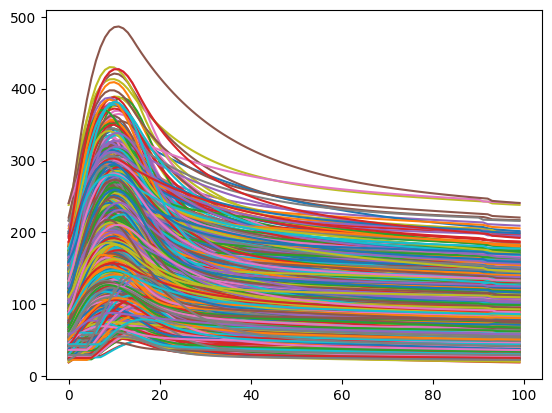

In [15]:
for _, row  in pressure_traces_df.iterrows():
    plt.plot(row.values[:100])
    
plt.show()

Here is an example of what the plotted pressure traces should look like:

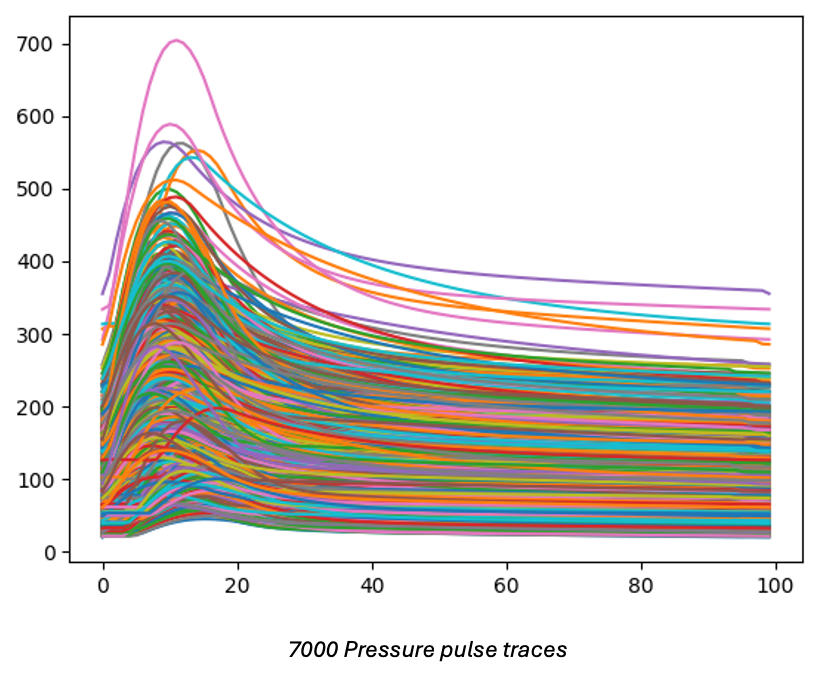